## Model Setting

- Feature map generator: fine tuning

- Depth cls head

- Depth map head


## Depth map prediction

In [1]:
!nvidia-smi

Sat Mar 11 19:39:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   44C    P8     8W / 320W |   1213MiB / 10018MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !pip install gdown

In [3]:
# import gdown 
# google_path = 'https://drive.google.com/uc?id='
# file_id = '17MHP5y2PwDAnVy05AglJQYotWfqOizpB'
# output_name = 'open.zip'
# gdown.download(google_path+file_id,output_name,quiet=False)

In [4]:
# !unzip open.zip

In [5]:
!pip install segmentation_models_pytorch

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import timm
import random
import pandas as pd
import numpy as np
import os
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action='ignore') 

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import albumentations as albu
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transforms
import sklearn
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast 

In [8]:
print('numpy verison :', np.__version__)
print('pandas version :', pd.__version__)
print('opencv version :', cv2.__version__)
print('torch version :', torch.__version__)
print('sklearn verison :', sklearn.__version__)
print('albumentations version :', albu.__version__)

numpy verison : 1.19.5
pandas version : 1.1.5
opencv version : 4.5.2
torch version : 1.7.0
sklearn verison : 0.24.2
albumentations version : 1.0.0


In [9]:
CFG = {
    'WIDTH':48,
    'HEIGHT':72,
    'EPOCHS':10,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':128,
    'SEED':41
}

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
simulation_sem_paths = sorted(glob.glob('./data/simulation_data/SEM/*/*/*.png'))

simulation_depth_paths = sorted(glob.glob('./data/simulation_data/Depth/*/*/*.png')*4)

test_sem_path_list = sorted(glob.glob('./data/test/SEM/*.png'))

train_sem_path_list = sorted(glob.glob('./data/train/SEM/*/*/*.png'))

In [12]:
simulation_sem_paths

['./data/simulation_data/SEM/Case_1/80/20201001_202940_NE142400C_RAE01_1_S01_M0005-01MS_3_itr0.png',
 './data/simulation_data/SEM/Case_1/80/20201001_202940_NE142400C_RAE01_1_S01_M0005-01MS_3_itr1.png',
 './data/simulation_data/SEM/Case_1/80/20201001_202940_NE142400C_RAE01_1_S01_M0006-01MS_3_itr0.png',
 './data/simulation_data/SEM/Case_1/80/20201001_202940_NE142400C_RAE01_1_S01_M0006-01MS_3_itr1.png',
 './data/simulation_data/SEM/Case_1/80/20201001_202940_NE142400C_RAE01_1_S01_M0009-01MS_3_itr0.png',
 './data/simulation_data/SEM/Case_1/80/20201001_202940_NE142400C_RAE01_1_S01_M0009-01MS_3_itr1.png',
 './data/simulation_data/SEM/Case_1/80/20201001_202940_NE142400C_RAE01_1_S01_M0029-01MS_1_itr0.png',
 './data/simulation_data/SEM/Case_1/80/20201001_202940_NE142400C_RAE01_1_S01_M0029-01MS_1_itr1.png',
 './data/simulation_data/SEM/Case_1/80/20201001_202940_NE142400C_RAE01_1_S01_M0030-01MS_2_itr0.png',
 './data/simulation_data/SEM/Case_1/80/20201001_202940_NE142400C_RAE01_1_S01_M0030-01MS_2_i

##  Unet

In [13]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.enabled = False
seed_everything(CFG['SEED']) # Seed 고정

In [14]:
# # to pad 0->left, 50->top, 100-> right, 150-> bottom
# transform = transforms.Pad((0,50,100,150))

In [15]:
class CustomDataset(Dataset):
    def __init__(self, sem_path_list, depth_path_list, mode):
        self.sem_path_list = sem_path_list
        self.depth_path_list = depth_path_list
        self.mode = mode
        if self.mode == 'train':
            self.transform = albu.Compose([albu.VerticalFlip(),
                                    albu.HorizontalFlip(),
                                    ToTensorV2(),
                                ], additional_targets= {'image1': 'image'})

        else:
            
            self.transform = albu.Compose([
                        ToTensorV2(),
                    ], additional_targets= {'image1': 'image'})


    def __getitem__(self, index):
        transform = transforms.Pad((8,12,8,12))
        
        sem_path = self.sem_path_list[index]
        sem_img = cv2.imread(sem_path, cv2.IMREAD_GRAYSCALE)
        # sem_img = np.expand_dims(sem_img, axis=-1).transpose(2,0,1)
        sem_img = sem_img / 255.

        depth_path = self.depth_path_list[index]
        depth_img = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)
        # depth_img = np.expand_dims(depth_img, axis=-1).transpose(2,0,1)
        depth_img = depth_img / 255.
        
        transformed = self.transform(image = sem_img, image1 = depth_img)
        sem_img = transformed['image']
        depth_img = transformed['image1']
        return transform(sem_img), transform(depth_img) # B,C,H,W

        
    def __len__(self):
        return len(self.sem_path_list)

In [16]:
#height=72, width=48
#(96, 64).

In [17]:
data_len = len(simulation_sem_paths)
train_idx = np.int_(np.random.choice(data_len, data_len, replace=False))
train_idx

array([ 37735,  60248, 160499, ...,  61324, 132003,  34752])

In [18]:
#array([189400, 342571, 123261, ..., 323468, 132003, 296896])

In [19]:
train_sem_paths = list(np.array(simulation_sem_paths)[train_idx[:np.int(data_len*0.8)]])
train_depth_paths = list(np.array(simulation_depth_paths)[train_idx[:np.int(data_len*0.8)]])

val_sem_paths = list(np.array(simulation_sem_paths)[train_idx[np.int(data_len*0.8):]])
val_depth_paths = list(np.array(simulation_depth_paths)[train_idx[np.int(data_len*0.8):]])


batch_size = CFG['BATCH_SIZE']

train_dataset = CustomDataset(train_sem_paths, train_depth_paths, mode='train')
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

val_dataset = CustomDataset(val_sem_paths, val_depth_paths, mode='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [20]:
model_map = smp.Unet(in_channels=1, activation = 'sigmoid')
model_map = model_map.to(device)
criterion_output = nn.L1Loss()
criterion_rmse = nn.MSELoss()
optimizer = torch.optim.Adam(params = model_map.parameters(), lr = CFG["LEARNING_RATE"])

In [21]:
len(train_loader)

1084

  0%|          | 0/11 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epochs: 1, 1-th
Max:  tensor(255., device='cuda:0') tensor(241.7999, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(10.8985, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(103.2863, device='cuda:0') tensor(125.2087, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(110.4851, device='cuda:0') tensor(41.4631, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 1, 501-th
Max:  tensor(255., device='cuda:0') tensor(254.9977, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0059, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(103.0005, device='cuda:0') tensor(104.4546, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(113.0058, device='cuda:0') tensor(112.0981, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 1, 1001-th
Max:  tensor(255., device='cuda:0') tensor(254.9992, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0012, device='cuda:0', grad_fn=<MulBackward0>)
M

  0%|          | 0/271 [00:00<?, ?it/s]

Epochs: 1
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0')
Min:  tensor(0., device='cuda:0') tensor(0., device='cuda:0')
Mean:  tensor(105.5135, device='cuda:0') tensor(104.8293, device='cuda:0')
Std:  tensor(113.2610, device='cuda:0') tensor(112.5254, device='cuda:0')


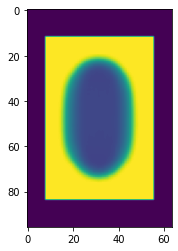

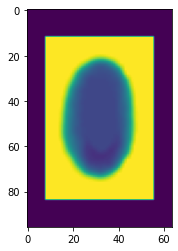

Epochs: 1, RMSE of the network on the test images: 8.1613876740431


0it [00:00, ?it/s]

Epochs: 2, 1-th
Max:  tensor(255., device='cuda:0') tensor(254.9994, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0010, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(105.2643, device='cuda:0') tensor(105.0733, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(111.9844, device='cuda:0') tensor(112.5483, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 2, 501-th
Max:  tensor(255., device='cuda:0') tensor(254.9998, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0004, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(102.0999, device='cuda:0') tensor(104.4523, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(110.8297, device='cuda:0') tensor(112.2324, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 2, 1001-th
Max:  tensor(255., device='cuda:0') tensor(254.9999, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0002, device='cuda:0', grad_fn=<MulBackward0>)
M

0it [00:00, ?it/s]

Epochs: 3, 1-th
Max:  tensor(255., device='cuda:0') tensor(254.9999, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0001, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(101.7341, device='cuda:0') tensor(104.4434, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(112.8813, device='cuda:0') tensor(112.5111, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 3, 501-th
Max:  tensor(255., device='cuda:0') tensor(255.0000, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(9.1505e-05, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(103.5304, device='cuda:0') tensor(104.3960, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(112.8074, device='cuda:0') tensor(112.4936, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 3, 1001-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(4.9934e-05, device='cuda:0', grad_fn=<MulBackward0

  0%|          | 0/271 [00:00<?, ?it/s]

Epochs: 3
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0')
Min:  tensor(0., device='cuda:0') tensor(0., device='cuda:0')
Mean:  tensor(104.1629, device='cuda:0') tensor(104.0872, device='cuda:0')
Std:  tensor(113.8060, device='cuda:0') tensor(112.5241, device='cuda:0')


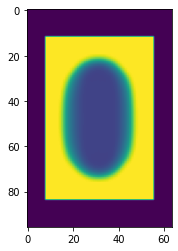

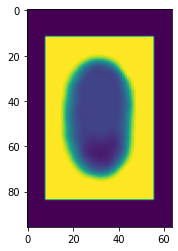

Epochs: 3, RMSE of the network on the test images: 8.071548440799502


0it [00:00, ?it/s]

Epochs: 4, 1-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(3.8311e-05, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(104.6818, device='cuda:0') tensor(104.9406, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(112.9096, device='cuda:0') tensor(112.4050, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 4, 501-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(2.5783e-05, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(104.5727, device='cuda:0') tensor(105.0006, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(112.8092, device='cuda:0') tensor(112.4854, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 4, 1001-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(1.6403e-05, device='cuda:0', grad_fn=<MulBackward0>)
M

0it [00:00, ?it/s]

Epochs: 5, 1-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(1.7308e-05, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(105.4383, device='cuda:0') tensor(104.4660, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(112.4349, device='cuda:0') tensor(112.1617, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 5, 501-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(9.3409e-06, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(104.0390, device='cuda:0') tensor(104.5357, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(111.8020, device='cuda:0') tensor(112.3184, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 5, 1001-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(6.2520e-06, device='cuda:0', grad_fn=<MulBackward0>)
M

  0%|          | 0/271 [00:00<?, ?it/s]

Epochs: 5
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0')
Min:  tensor(0., device='cuda:0') tensor(0., device='cuda:0')
Mean:  tensor(103.3179, device='cuda:0') tensor(103.7293, device='cuda:0')
Std:  tensor(111.6977, device='cuda:0') tensor(112.4747, device='cuda:0')


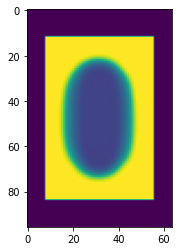

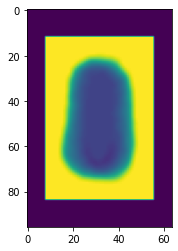

Epochs: 5, RMSE of the network on the test images: 8.067988235572168


0it [00:00, ?it/s]

Epochs: 6, 1-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(5.1136e-06, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(103.9075, device='cuda:0') tensor(103.2908, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(111.9440, device='cuda:0') tensor(112.0784, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 6, 501-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(4.1283e-06, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(105.7537, device='cuda:0') tensor(104.2852, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(111.4450, device='cuda:0') tensor(112.1821, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 6, 1001-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(2.2824e-06, device='cuda:0', grad_fn=<MulBackward0>)
M

0it [00:00, ?it/s]

Epochs: 7, 1-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(1.7383e-06, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(104.3165, device='cuda:0') tensor(103.9622, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(112.4753, device='cuda:0') tensor(112.3580, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 7, 501-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(8.8795e-07, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(102.6242, device='cuda:0') tensor(104.0512, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(112.8451, device='cuda:0') tensor(112.5367, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 7, 1001-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(5.2291e-07, device='cuda:0', grad_fn=<MulBackward0>)
M

  0%|          | 0/271 [00:00<?, ?it/s]

Epochs: 7
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0')
Min:  tensor(0., device='cuda:0') tensor(0., device='cuda:0')
Mean:  tensor(104.8434, device='cuda:0') tensor(103.9771, device='cuda:0')
Std:  tensor(113.0414, device='cuda:0') tensor(112.5917, device='cuda:0')


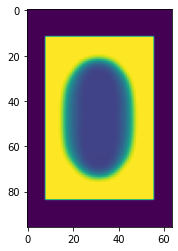

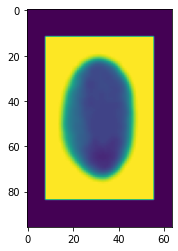

Epochs: 7, RMSE of the network on the test images: 8.218335368096609


0it [00:00, ?it/s]

Epochs: 8, 1-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(2.7744e-07, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(105.6476, device='cuda:0') tensor(103.9016, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(110.4313, device='cuda:0') tensor(112.3548, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 8, 501-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(2.9101e-07, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(103.6477, device='cuda:0') tensor(103.6258, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(113.1682, device='cuda:0') tensor(112.3832, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 8, 1001-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(6.6199e-08, device='cuda:0', grad_fn=<MulBackward0>)
M

0it [00:00, ?it/s]

Epochs: 9, 1-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(1.7936e-07, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(103.6347, device='cuda:0') tensor(103.6231, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(113.0564, device='cuda:0') tensor(112.4671, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 9, 501-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(7.1699e-08, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(105.2963, device='cuda:0') tensor(104.5889, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(112.6909, device='cuda:0') tensor(112.2853, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 9, 1001-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(3.9733e-08, device='cuda:0', grad_fn=<MulBackward0>)
M

  0%|          | 0/271 [00:00<?, ?it/s]

Epochs: 9
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0')
Min:  tensor(0., device='cuda:0') tensor(0., device='cuda:0')
Mean:  tensor(102.3086, device='cuda:0') tensor(103.8569, device='cuda:0')
Std:  tensor(111.2514, device='cuda:0') tensor(112.5324, device='cuda:0')


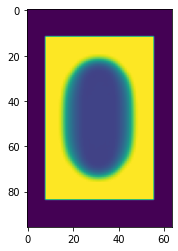

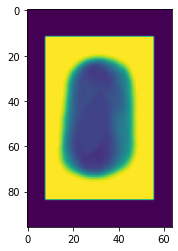

Epochs: 9, RMSE of the network on the test images: 8.01198631547034


0it [00:00, ?it/s]

Epochs: 10, 1-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(2.4199e-08, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(104.3956, device='cuda:0') tensor(103.8909, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(113.2828, device='cuda:0') tensor(112.5994, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 10, 501-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(1.4376e-08, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(100.1804, device='cuda:0') tensor(104.0835, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(110.1778, device='cuda:0') tensor(112.7025, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 10, 1001-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(1.1137e-08, device='cuda:0', grad_fn=<MulBackward0>

0it [00:00, ?it/s]

Epochs: 11, 1-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(6.3768e-09, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(104.5362, device='cuda:0') tensor(104.3176, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(112.1124, device='cuda:0') tensor(112.0633, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 11, 501-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(3.7964e-09, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(99.4201, device='cuda:0') tensor(103.8033, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(113.1014, device='cuda:0') tensor(112.5230, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 11, 1001-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(7.2501e-10, device='cuda:0', grad_fn=<MulBackward0>)

  0%|          | 0/271 [00:00<?, ?it/s]

Epochs: 11
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0')
Min:  tensor(0., device='cuda:0') tensor(0., device='cuda:0')
Mean:  tensor(104.8164, device='cuda:0') tensor(103.8827, device='cuda:0')
Std:  tensor(112.8231, device='cuda:0') tensor(112.4989, device='cuda:0')


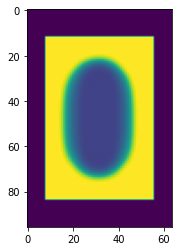

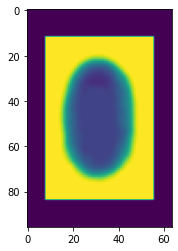

Epochs: 11, RMSE of the network on the test images: 7.98715325211247
Finished Training


In [22]:
pbar = tqdm(range(CFG['EPOCHS']+1))

for epoch in pbar:   # 데이터셋을 수차례 반복합니다.
    model_map.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader, 0)):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        sem, depth = data

        
        sem = sem.float().to(device)

        depth = depth.float().to(device)

        mx = torch.cat([torch.max(depth[i]).reshape(1,1,1,1) for i in range(len(depth))])
#         print(mx.shape)
        depth = depth/mx

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        pred_output  = model_map(sem)
        
        loss =  criterion_output(pred_output, depth)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()

        
        if i % 500 == 0:    # print every 2000 mini-batches
            pbar.set_description(f'Epochs: {epoch + 1}, {i+1}-th, Train loss: {running_loss / 500:.6f}')
            running_loss = 0.0
            
            print(f'Epochs: {epoch + 1}, {i+1}-th')
            print('Max: ',torch.max(depth[0][0])*255, torch.max(pred_output[0])*255)
            print('Min: ',torch.min(depth[0][0])*255, torch.min(pred_output[0])*255)
            print('Mean: ',torch.mean(depth[0][0])*255, torch.mean(pred_output[0])*255)
            print('Std: ',torch.std(depth[0][0]*255), torch.std(pred_output[0]*255))
        
        


    if epoch % 2 == 0:
        model_map.eval()
        val_rmse = []
        # 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
        cnt = 0
        with torch.no_grad():
            for data in tqdm(val_loader):
                
                sem, depth = data
                
                sem = sem.float().to(device)
                depth = depth.float().to(device)
                mx = torch.cat([torch.max(depth[i]).reshape(1,1,1,1) for i in range(len(depth))])
            
                depth = depth/mx

#                 print(depth.shape)
#                 feature = feature_extractor(sem)
                model_pred = model_map(sem)
                pred = torch.round(model_pred*255.)
                true =  torch.round(depth*255.)

                b_rmse = torch.sqrt(criterion_rmse(pred, true))
                
        
                if cnt == 5:
                
                    print(f'Epochs: {epoch + 1}')
                    print('Max: ',torch.max(true[0]), torch.max(pred[0]))
                    print('Min: ',torch.min(true[0]), torch.min(pred[0]))
                    print('Mean: ',torch.mean(true[0]), torch.mean(pred[0]))
                    print('Std: ',torch.std(true[0]), torch.std(pred[0]))

                    plt.imshow(model_pred[0][0].cpu().detach().numpy() , vmin= 0, vmax=1  )
                    plt.show()
                    plt.imshow(depth[0][0].cpu().detach().numpy() , vmin= 0, vmax=1  )
                    plt.show()
                    
                cnt += 1
                val_rmse.append(b_rmse.item())

        print(f'Epochs: {epoch + 1}, RMSE of the network on the test images: {np.mean(val_rmse)}')
print('Finished Training')

In [23]:
# EPOCH: 15

In [24]:
torch.save(model_map.state_dict(), "./weight/map_model_Unet.pt")        

##  Linknet

In [25]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.enabled = False
seed_everything(CFG['SEED']+1) # Seed 고정

In [26]:
class CustomDataset(Dataset):
    def __init__(self, sem_path_list, depth_path_list, mode):
        self.sem_path_list = sem_path_list
        self.depth_path_list = depth_path_list
        self.mode = mode
        if self.mode == 'train':
            self.transform = albu.Compose([albu.VerticalFlip(),
                                    albu.HorizontalFlip(),
                                    ToTensorV2(),
                                ], additional_targets= {'image1': 'image'})

        else:
            
            self.transform = albu.Compose([
                        ToTensorV2(),
                    ], additional_targets= {'image1': 'image'})


    def __getitem__(self, index):
        transform = transforms.Pad((8,12,8,12))
        
        sem_path = self.sem_path_list[index]
        sem_img = cv2.imread(sem_path, cv2.IMREAD_GRAYSCALE)
        # sem_img = np.expand_dims(sem_img, axis=-1).transpose(2,0,1)
        sem_img = sem_img / 255.

        depth_path = self.depth_path_list[index]
        depth_img = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)
        # depth_img = np.expand_dims(depth_img, axis=-1).transpose(2,0,1)
        depth_img = depth_img / 255.
        
        transformed = self.transform(image = sem_img, image1 = depth_img)
        sem_img = transformed['image']
        depth_img = transformed['image1']
        return transform(sem_img), transform(depth_img) # B,C,H,W

        
    def __len__(self):
        return len(self.sem_path_list)

In [27]:
data_len = len(simulation_sem_paths)
train_idx = np.int_(np.random.choice(data_len, data_len, replace=False))
train_idx

array([ 60488,  29760,  11514, ..., 131932, 146867, 121958])

In [28]:
train_sem_paths = list(np.array(simulation_sem_paths)[train_idx[:np.int(data_len*0.8)]])
train_depth_paths = list(np.array(simulation_depth_paths)[train_idx[:np.int(data_len*0.8)]])

val_sem_paths = list(np.array(simulation_sem_paths)[train_idx[np.int(data_len*0.8):]])
val_depth_paths = list(np.array(simulation_depth_paths)[train_idx[np.int(data_len*0.8):]])


batch_size = CFG['BATCH_SIZE']

train_dataset = CustomDataset(train_sem_paths, train_depth_paths, mode='train')
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

val_dataset = CustomDataset(val_sem_paths, val_depth_paths, mode='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [29]:
model_map = smp.Linknet(in_channels=1, activation = 'sigmoid')
model_map = model_map.to(device)
criterion_output = nn.L1Loss()
criterion_rmse = nn.MSELoss()
optimizer = torch.optim.Adam(params = model_map.parameters(), lr = CFG["LEARNING_RATE"])

  0%|          | 0/11 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epochs: 1, 1-th
Max:  tensor(255., device='cuda:0') tensor(249.2297, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(34.8289, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(105.3950, device='cuda:0') tensor(140.6304, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(113.2319, device='cuda:0') tensor(37.5171, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 1, 501-th
Max:  tensor(255., device='cuda:0') tensor(254.9854, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0772, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(105.8213, device='cuda:0') tensor(104.8218, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(111.9469, device='cuda:0') tensor(112.2164, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 1, 1001-th
Max:  tensor(255., device='cuda:0') tensor(254.9970, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0123, device='cuda:0', grad_fn=<MulBackward0>)
M

  0%|          | 0/271 [00:00<?, ?it/s]

Epochs: 1
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0')
Min:  tensor(0., device='cuda:0') tensor(0., device='cuda:0')
Mean:  tensor(104.0941, device='cuda:0') tensor(103.9435, device='cuda:0')
Std:  tensor(112.7541, device='cuda:0') tensor(112.6176, device='cuda:0')


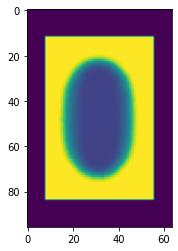

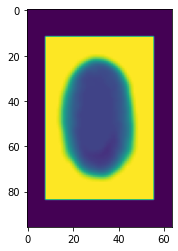

Epochs: 1, RMSE of the network on the test images: 8.174691048935331


0it [00:00, ?it/s]

Epochs: 2, 1-th
Max:  tensor(255., device='cuda:0') tensor(254.9978, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0089, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(103.9479, device='cuda:0') tensor(104.0656, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(112.9621, device='cuda:0') tensor(112.4027, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 2, 501-th
Max:  tensor(255., device='cuda:0') tensor(254.9977, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0030, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(105.1359, device='cuda:0') tensor(104.5159, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(112.2192, device='cuda:0') tensor(112.4212, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 2, 1001-th
Max:  tensor(255., device='cuda:0') tensor(254.9996, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0013, device='cuda:0', grad_fn=<MulBackward0>)
M

0it [00:00, ?it/s]

Epochs: 3, 1-th
Max:  tensor(255., device='cuda:0') tensor(254.9995, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0013, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(106.0078, device='cuda:0') tensor(104.0574, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(112.0812, device='cuda:0') tensor(112.0757, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 3, 501-th
Max:  tensor(255., device='cuda:0') tensor(254.9998, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0007, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(104.2974, device='cuda:0') tensor(103.9969, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(113.0139, device='cuda:0') tensor(112.5256, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 3, 1001-th
Max:  tensor(255., device='cuda:0') tensor(254.9998, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0005, device='cuda:0', grad_fn=<MulBackward0>)
M

  0%|          | 0/271 [00:00<?, ?it/s]

Epochs: 3
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0')
Min:  tensor(0., device='cuda:0') tensor(0., device='cuda:0')
Mean:  tensor(104.4006, device='cuda:0') tensor(103.9372, device='cuda:0')
Std:  tensor(112.5349, device='cuda:0') tensor(112.5721, device='cuda:0')


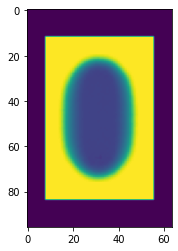

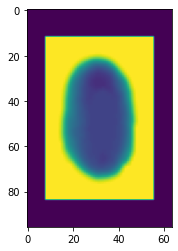

Epochs: 3, RMSE of the network on the test images: 8.037340450990683


0it [00:00, ?it/s]

Epochs: 4, 1-th
Max:  tensor(255., device='cuda:0') tensor(254.9999, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0005, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(102.5600, device='cuda:0') tensor(103.9783, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(112.0343, device='cuda:0') tensor(112.4347, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 4, 501-th
Max:  tensor(255., device='cuda:0') tensor(254.9999, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0003, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(104.4502, device='cuda:0') tensor(104.3891, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(112.9744, device='cuda:0') tensor(112.2396, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 4, 1001-th
Max:  tensor(255., device='cuda:0') tensor(254.9999, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0002, device='cuda:0', grad_fn=<MulBackward0>)
M

0it [00:00, ?it/s]

Epochs: 5, 1-th
Max:  tensor(255., device='cuda:0') tensor(255.0000, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0002, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(104.1994, device='cuda:0') tensor(103.6893, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(113.0330, device='cuda:0') tensor(112.5622, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 5, 501-th
Max:  tensor(255., device='cuda:0') tensor(254.9999, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0002, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(101.9022, device='cuda:0') tensor(104.5076, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(110.5213, device='cuda:0') tensor(112.2077, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 5, 1001-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0001, device='cuda:0', grad_fn=<MulBackward0>)
Mean:

  0%|          | 0/271 [00:00<?, ?it/s]

Epochs: 5
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0')
Min:  tensor(0., device='cuda:0') tensor(0., device='cuda:0')
Mean:  tensor(103.1073, device='cuda:0') tensor(103.2562, device='cuda:0')
Std:  tensor(112.4671, device='cuda:0') tensor(112.0482, device='cuda:0')


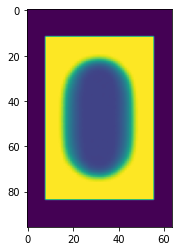

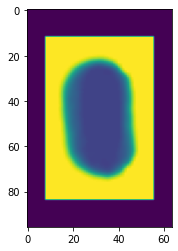

Epochs: 5, RMSE of the network on the test images: 8.567360754822452


0it [00:00, ?it/s]

Epochs: 6, 1-th
Max:  tensor(255., device='cuda:0') tensor(255.0000, device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(0.0001, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(105.0242, device='cuda:0') tensor(104.2200, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(112.1780, device='cuda:0') tensor(112.0640, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 6, 501-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(8.9522e-05, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(101.3293, device='cuda:0') tensor(104.2435, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(112.7039, device='cuda:0') tensor(112.7167, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 6, 1001-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(6.4716e-05, device='cuda:0', grad_fn=<MulBackward0>)
M

0it [00:00, ?it/s]

Epochs: 7, 1-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(7.7811e-05, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(101.4696, device='cuda:0') tensor(103.8493, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(111.0764, device='cuda:0') tensor(112.5123, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 7, 501-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(5.9579e-05, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(100.2223, device='cuda:0') tensor(103.8963, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(110.3717, device='cuda:0') tensor(112.4536, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 7, 1001-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(4.5227e-05, device='cuda:0', grad_fn=<MulBackward0>)
M

  0%|          | 0/271 [00:00<?, ?it/s]

Epochs: 7
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0')
Min:  tensor(0., device='cuda:0') tensor(0., device='cuda:0')
Mean:  tensor(103.8555, device='cuda:0') tensor(103.9552, device='cuda:0')
Std:  tensor(112.7101, device='cuda:0') tensor(112.5178, device='cuda:0')


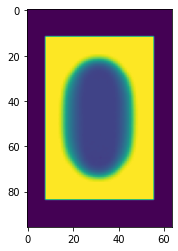

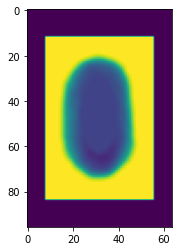

Epochs: 7, RMSE of the network on the test images: 8.05607023626236


0it [00:00, ?it/s]

Epochs: 8, 1-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(4.2576e-05, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(102.5250, device='cuda:0') tensor(103.8104, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(110.6299, device='cuda:0') tensor(111.7104, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 8, 501-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(3.3604e-05, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(104.8273, device='cuda:0') tensor(104.0761, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(113.3198, device='cuda:0') tensor(112.5305, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 8, 1001-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(1.8479e-05, device='cuda:0', grad_fn=<MulBackward0>)
M

0it [00:00, ?it/s]

Epochs: 9, 1-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(1.9970e-05, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(103.2884, device='cuda:0') tensor(104.6215, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(112.8267, device='cuda:0') tensor(112.4237, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 9, 501-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(1.2549e-05, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(104.3598, device='cuda:0') tensor(104.3633, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(113.4062, device='cuda:0') tensor(112.2990, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 9, 1001-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(1.0427e-05, device='cuda:0', grad_fn=<MulBackward0>)
M

  0%|          | 0/271 [00:00<?, ?it/s]

Epochs: 9
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0')
Min:  tensor(0., device='cuda:0') tensor(0., device='cuda:0')
Mean:  tensor(103.5726, device='cuda:0') tensor(104.7015, device='cuda:0')
Std:  tensor(111.1780, device='cuda:0') tensor(112.4508, device='cuda:0')


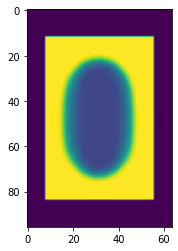

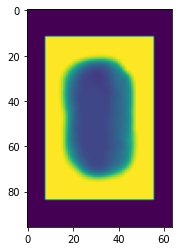

Epochs: 9, RMSE of the network on the test images: 8.109992300012454


0it [00:00, ?it/s]

Epochs: 10, 1-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(1.0464e-05, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(105.7917, device='cuda:0') tensor(104.4122, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(112.9419, device='cuda:0') tensor(112.3467, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 10, 501-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(7.6983e-06, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(103.8351, device='cuda:0') tensor(104.4689, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(111.9804, device='cuda:0') tensor(112.3224, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 10, 1001-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(4.5140e-06, device='cuda:0', grad_fn=<MulBackward0>

0it [00:00, ?it/s]

Epochs: 11, 1-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(4.9136e-06, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(102.2927, device='cuda:0') tensor(103.8851, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(111.0956, device='cuda:0') tensor(112.6173, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 11, 501-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(3.8599e-06, device='cuda:0', grad_fn=<MulBackward0>)
Mean:  tensor(105.1404, device='cuda:0') tensor(104.3231, device='cuda:0', grad_fn=<MulBackward0>)
Std:  tensor(113.3950, device='cuda:0') tensor(112.4114, device='cuda:0', grad_fn=<StdBackward0>)
Epochs: 11, 1001-th
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0', grad_fn=<MulBackward0>)
Min:  tensor(0., device='cuda:0') tensor(2.5862e-06, device='cuda:0', grad_fn=<MulBackward0>

  0%|          | 0/271 [00:00<?, ?it/s]

Epochs: 11
Max:  tensor(255., device='cuda:0') tensor(255., device='cuda:0')
Min:  tensor(0., device='cuda:0') tensor(0., device='cuda:0')
Mean:  tensor(103.2860, device='cuda:0') tensor(104.0067, device='cuda:0')
Std:  tensor(112.7978, device='cuda:0') tensor(112.5377, device='cuda:0')


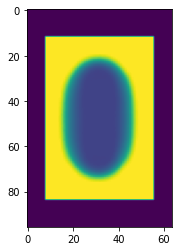

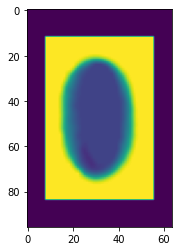

Epochs: 11, RMSE of the network on the test images: 8.089324270227298
Finished Training


In [30]:
pbar = tqdm(range(CFG['EPOCHS']+1))

for epoch in pbar:   # 데이터셋을 수차례 반복합니다.
    model_map.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader, 0)):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        sem, depth = data

        
        sem = sem.float().to(device)

        depth = depth.float().to(device)

        mx = torch.cat([torch.max(depth[i]).reshape(1,1,1,1) for i in range(len(depth))])
#         print(mx.shape)
        depth = depth/mx

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        pred_output  = model_map(sem)
        
        loss =  criterion_output(pred_output, depth)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()

        
        if i % 500 == 0:    # print every 2000 mini-batches
            pbar.set_description(f'Epochs: {epoch + 1}, {i+1}-th, Train loss: {running_loss / 500:.6f}')
            running_loss = 0.0
            
            print(f'Epochs: {epoch + 1}, {i+1}-th')
            print('Max: ',torch.max(depth[0][0])*255, torch.max(pred_output[0])*255)
            print('Min: ',torch.min(depth[0][0])*255, torch.min(pred_output[0])*255)
            print('Mean: ',torch.mean(depth[0][0])*255, torch.mean(pred_output[0])*255)
            print('Std: ',torch.std(depth[0][0]*255), torch.std(pred_output[0]*255))
        
        


    if epoch % 2 == 0:
        model_map.eval()
        val_rmse = []
        # 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
        cnt = 0
        with torch.no_grad():
            for data in tqdm(val_loader):
                
                sem, depth = data
                
                sem = sem.float().to(device)
                depth = depth.float().to(device)
                mx = torch.cat([torch.max(depth[i]).reshape(1,1,1,1) for i in range(len(depth))])
            
                depth = depth/mx

#                 print(depth.shape)
#                 feature = feature_extractor(sem)
                model_pred = model_map(sem)
                pred = torch.round(model_pred*255.)
                true =  torch.round(depth*255.)

                b_rmse = torch.sqrt(criterion_rmse(pred, true))
                
        
                if cnt == 5:
                
                    print(f'Epochs: {epoch + 1}')
                    print('Max: ',torch.max(true[0]), torch.max(pred[0]))
                    print('Min: ',torch.min(true[0]), torch.min(pred[0]))
                    print('Mean: ',torch.mean(true[0]), torch.mean(pred[0]))
                    print('Std: ',torch.std(true[0]), torch.std(pred[0]))

                    plt.imshow(model_pred[0][0].cpu().detach().numpy() , vmin= 0, vmax=1  )
                    plt.show()
                    plt.imshow(depth[0][0].cpu().detach().numpy() , vmin= 0, vmax=1  )
                    plt.show()
                    
                cnt += 1
                val_rmse.append(b_rmse.item())

        print(f'Epochs: {epoch + 1}, RMSE of the network on the test images: {np.mean(val_rmse)}')
print('Finished Training')

In [31]:
torch.save(model_map.state_dict(), "./weight/map_model_Linknet.pt")        